# Modelling dose–response relationships using data fitting

The following is the Python code used to fit a nonlinear regression model to dose–response data of a chemical taken from the US National Toxicology Program library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from naginterfaces.library import opt
from naginterfaces.base import utils

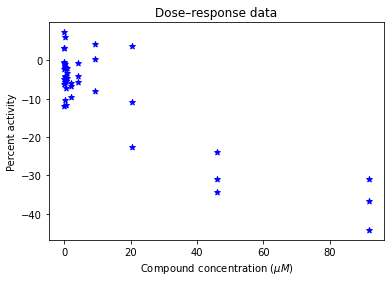

In [2]:
# read in the data
df = pd.read_csv('dose_resp.dat', header=None) 
data = df.values
t, y = data[:, 0], data[:, 1]

# plot input vs output
plt.scatter(t, y, marker='*', color='b')
plt.xlabel(r"Compound concentration ($\mu M$)")
plt.ylabel("Percent activity")
plt.title("Dose–response data")
plt.show()

## Fit the model with the good starting point:

In [3]:
# create a handle for the model
nvar = 4
handle = opt.handle_init(nvar=nvar)

# register residual structure
nres = len(t)
opt.handle_set_nlnls(handle, nres)

# define the residual callback function
def lsqfun(x, nres, inform, data):
    rx = np.zeros(nres, dtype=float)
    t = data["t"]
    y = data["y"]
    
    # fit the hill function to the data
    for i in range(nres):
        rx[i] = (y[i] - (x[0] + ((x[1] - x[0]) / (1 + (x[2] / t[i])**x[3]))))
    
    return rx, inform

# define the residual gradient
def lsqgrd(x, nres, rdx, inform, data):
    t = data["t"]
    nvar = len(x)

    for i in range(nres):
        rdx[i*nvar] = -1 + (1 / (1 + (x[2] / t[i])**x[3]))
        rdx[i*nvar + 1] = -(1 /  (1 + (x[2] / t[i])**x[3]))
        rdx[i*nvar + 2] = (x[1] - x[0]) * ((x[3] * x[2]**(x[3] - 1)) / (t[i]**x[3] * (1 + (x[2]**x[3] / t[i]**x[3]))**2))
        rdx[i*nvar + 3] = (x[1] - x[0]) * np.log((x[2] / t[i])) * (x[2] / t[i])**x[3] * (1 / (1 + (x[2] / t[i])**x[3])**2)
        
    return inform

# create the data structure to be passed to the solver
data = {}
data["t"] = t
data["y"] = y

# set loss function to l2-norm and printing options
for option in [
    'NLDF Loss Function Type = L2',
    'Print Level = 1',
    'Print Options = No',
    'Print solution = Yes',
    ]:
    opt.handle_opt_set (handle, option)

# mute warnings
warnings.filterwarnings("ignore")
# use an explicit I/O manager for abbreviated iteration output:
iom = utils.FileObjManager(locus_in_output=False)

# set initial guess and solve
x = [-40., -5., 30., -5.]

sol = opt.handle_solve_nldf(handle, lsqfun, lsqgrd, x, nres,data=data, io_manager=iom)

 E04GN, Nonlinear Data-Fitting
 Status: converged, an optimal solution found
 Final objective value  1.219791E+03

 Primal variables:
   idx   Lower bound       Value       Upper bound
     1       -inf      -3.81844E+01         inf
     2       -inf      -3.36193E+00         inf
     3       -inf       3.25418E+01         inf
     4       -inf      -3.39512E+00         inf


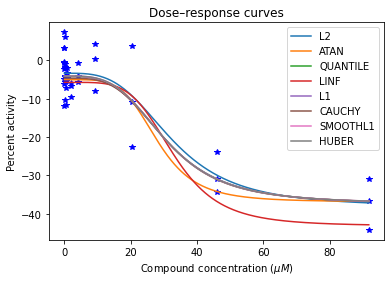

In [4]:
# plot result from NLS
plt.title("Dose–response curves")
plt.plot(t, y, '*b')
dose = np.linspace(0.0005874, 91.74, 1000)
resp = sol.x[0] + ((sol.x[1] - sol.x[0]) / (1 + (sol.x[2] / dose)**sol.x[3]))
plt.plot(dose, resp, label='L2')

# fit all loss functions and plot results
# loss function types
lossfuns = {'HUBER', 'L1', 'LINF', 'CAUCHY', 'ATAN', 'SMOOTHL1', 'QUANTILE'}

# turn off log printing
opt.handle_opt_set(handle, 'Print File = -1')

for lossfun in lossfuns:
    
    # set option for the loss function
    opt.handle_opt_set(handle, 'NLDF Loss Function Type = ' + lossfun)
    
    # call the solver
    sol = opt.handle_solve_nldf(handle, lsqfun, lsqgrd, x, nres, data=data, io_manager=iom)
    
    # calculate response using fitted parameters
    resp = sol.x[0] + ((sol.x[1] - sol.x[0]) / (1 + (sol.x[2] / dose)**sol.x[3]))
    
    # plot curve
    plt.plot(dose, resp, label=lossfun)

# show the plot
plt.xlabel(r"Compound concentration ($\mu M$)")
plt.ylabel("Percent activity")
plt.legend()
plt.show()

## Fit the model with the naive starting point and different regularisation functions:

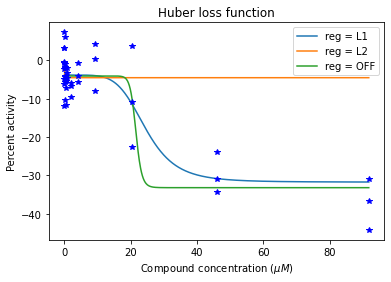

In [5]:
# set loss function to huber
opt.handle_opt_set (handle, 'NLDF Loss Function Type = HUBER')

# set initial guess and solve
x = [30., 30., 30., 30.]

# regularisation types
regs = {'OFF', 'L1', 'L2'}

# solve huber loss function with various regularisations
for reg in regs:
    # set reg type
    opt.handle_opt_set(handle, 'Reg Term Type =' + reg)
    # call the solver
    sol = opt.handle_solve_nldf(handle, lsqfun, lsqgrd, x, nres,data=data, io_manager=iom)
    # calculate response
    resp = sol.x[0] + ((sol.x[1] - sol.x[0]) / (1 + (sol.x[2] / dose)**sol.x[3]))
    # plot curve
    plt.plot(dose, resp, label='reg = '+reg)

# show huber curves
plt.title("Huber loss function")
plt.plot(t, y, '*b')
plt.xlabel(r"Compound concentration ($\mu M$)")
plt.ylabel("Percent activity")
plt.legend()
plt.show()

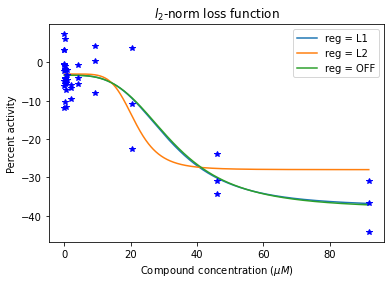

In [6]:
# set loss function to NLS
opt.handle_opt_set (handle, 'NLDF Loss Function Type = L2')

# solve NLS loss function with various regularisations
for reg in regs:
    # set reg type
    opt.handle_opt_set(handle, 'Reg Term Type =' + reg)
    # call the solver
    sol = opt.handle_solve_nldf(handle, lsqfun, lsqgrd, x, nres,data=data, io_manager=iom)
    # calculate response
    resp = sol.x[0] + ((sol.x[1] - sol.x[0]) / (1 + (sol.x[2] / dose)**sol.x[3]))
    # plot curve
    plt.plot(dose, resp, label='reg = '+reg)

# show NLS curves
plt.title(r"$l_2$-norm loss function")
plt.plot(t, y, '*b')
plt.xlabel(r"Compound concentration ($\mu M$)")
plt.ylabel("Percent activity")
plt.legend()
plt.show()

In [7]:
# destroy the handle
opt.handle_free(handle)